In [1]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd

from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

from randn2 import randn2 
import peer_functions as peer

import math
from tqdm import tqdm
os.environ['OPENBLAS_NUM_THREADS'] = '1'

from datasets import ExperimentRunner
import time



c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\lava\utils\profiler.py:16: UserWarning: Loihi2HWProfiler could not be imported. Currently no profiler is available.
  warnings.warn("Loihi2HWProfiler could not be imported. "


In [2]:
def calculate_evaluation_metrics(similarity_matrix, ground_truth):
    """
    Calculate evaluation metrics for place recognition results
    
    Args:
        similarity_matrix: Matrix of similarity scores between queries and database
        ground_truth: Ground truth data containing GThard and GTsoft
        
    Returns:
        dict: Dictionary containing recalls, precision, recall curves and AUC
    """
    # Get candidate selections
    ids_pos = peer.directCandSel(similarity_matrix)
    
    # Calculate recall values
    recalls = peer.getRecallAtKVector(ids_pos, ground_truth["GT"])
    
    # Calculate precision-recall curves and AUC
    [R, P] = peer.createPR(-similarity_matrix, 
                          ground_truth['GT']["GThard"][0][0], 
                          ground_truth['GT']["GTsoft"][0][0])
    auc = np.trapz(P, R)
    
    return {
        'recalls': recalls,
        'precision': P,
        'recall': R,
        'auc': auc
    }



In [3]:
D1    = loadmat("../datasets/descriptors/GardensPointWalking/day_left/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/GardensPointWalking/night_right/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']


g_truth = loadmat("../datasets/ground_truth/GardensPointWalking/day_left--night_right/gt.mat")

# D1    = loadmat("../datasets/descriptors/CMU/20110421/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
# D2    = loadmat("../datasets/descriptors/CMU/20100901/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

# g_truth = loadmat("../datasets/ground_truth/CMU/20110421--20100901/gt.mat")


# D1    = loadmat("../datasets/descriptors/Nordland1000/spring/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
# D2    = loadmat("../datasets/descriptors/Nordland1000/winter/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

# g_truth = loadmat("../datasets/ground_truth/Nordland1000/spring--winter/gt.mat")


## CPU Experiment

In [4]:
# Compute dot product between all pairs of vectors
dot_product_matrix = np.dot(D1, D2.T)  # This will give a 200x200 matrix

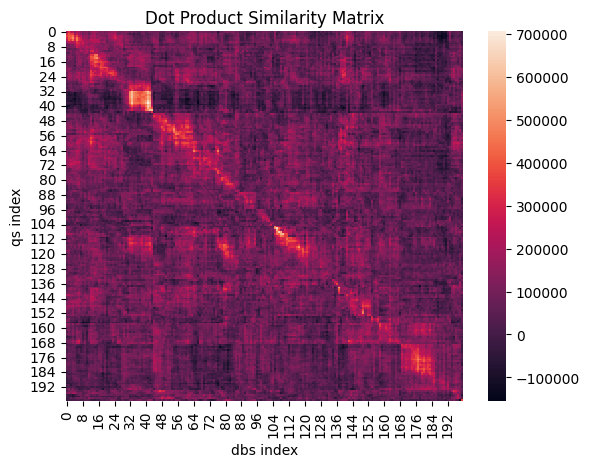

In [5]:
import seaborn as sns

ax = sns.heatmap(dot_product_matrix)
plt.title('Dot Product Similarity Matrix')
plt.xlabel('dbs index')
plt.ylabel('qs index')
plt.show()

In [6]:
metrics = calculate_evaluation_metrics(-dot_product_matrix, g_truth)
print(f"AUC: {metrics['auc']}")

AUC: 0.3483199833406223


In [7]:
np.__config__.show()

openblas64__info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['openblas\\lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BLAS_SYMBOL_SUFFIX', '64_'), ('HAVE_BLAS_ILP64', None)]
    runtime_library_dirs = ['openblas\\lib']
blas_ilp64_opt_info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['openblas\\lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BLAS_SYMBOL_SUFFIX', '64_'), ('HAVE_BLAS_ILP64', None)]
    runtime_library_dirs = ['openblas\\lib']
openblas64__lapack_info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['openblas\\lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BLAS_SYMBOL_SUFFIX', '64_'), ('HAVE_BLAS_ILP64', None), ('HAVE_LAPACKE', None)]
    runtime_library_dirs = ['openblas\\lib']
lapack_ilp64_opt_info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['openblas\\lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BL

In [8]:
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [9]:
from dot_product import CPUDotProductPositiveForLoop

# Create list to store sizes and times
sizes = []
times = []
NUM_RUNS = 5

positive_value = 1/math.sqrt(2)

# Test different sizes by adding 50 vectors each time
for increment in tqdm(range(1, 11), desc='Testing different sizes'):  # 10 different sizes
    # Calculate how many vectors to use (original size + increments of 50)
    num_vectors = D1.shape[0] + (increment - 1) * 50
    
    # Take the first num_vectors rows from D1, repeating if necessary
    full_repeats = num_vectors // D1.shape[0]
    remaining_vectors = num_vectors % D1.shape[0]
    
    D1_parts = [D1] * full_repeats
    if remaining_vectors > 0:
        D1_parts.append(D1[:remaining_vectors])
    
    D1_large = np.concatenate(D1_parts, axis=0)
    
    # List to store times for this size
    size_times = []
    
    dot = CPUDotProductPositiveForLoop(D1_large, D2, positive_value)
    # Run multiple times for each size
    for _ in range(NUM_RUNS):
        dot.pre_run()
        start_time = time.time()
        dot.run()
        end_time = time.time()
        size_times.append((end_time - start_time)*1000)
    
    # Store results
    sizes.append(D1_large.shape[0])
    times.append(np.mean(size_times))
    
    # Clean up
    del D1_large
    gc.collect()

Testing different sizes:   0%|          | 0/10 [00:00<?, ?it/s]

Testing different sizes: 100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


In [14]:
import pyRAPL

pyRAPL.setup() 

@pyRAPL.measure
def foo():
    # Instructions to be evaluated.
    for i in range(100000):
        gen = np.random.binomial(10000)

foo()

 You need to install pymongo>=3.9.0 in order to use MongoOutput 


FileNotFoundError: [Errno 2] No such file or directory: '/sys/devices/system/cpu/present'

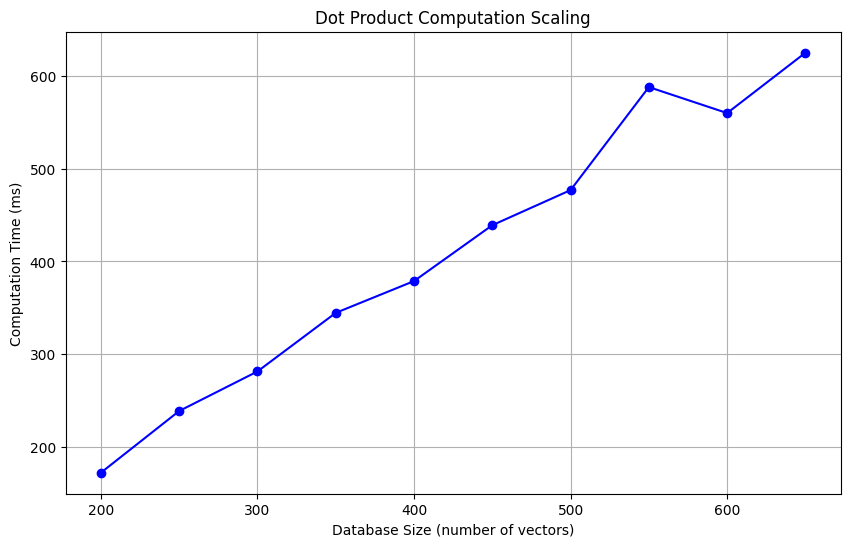

In [10]:

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sizes, times, 'bo-')
plt.xlabel('Database Size (number of vectors)')
plt.ylabel('Computation Time (ms)')
plt.title('Dot Product Computation Scaling')
plt.grid(True)
plt.show()


## Loihi Results

In [12]:
# Update the data with DB: 350 metrics
db_values = [200, 300, 350, 400, 450]
execution_time = [7.75, 14.392, 13.488, 18.848, 20.705]  # in ms
total_power = [1.767, 1.228, 1.509, 1.501]  # in W
total_energy = [0.013694, 0.016563, 0.028442, 0.031078]  # in J
static_energy = [0.011687, 0.022471, 0.040071, 0.037994]  # in J
dynamic_power = [0.259, -0.438, -0.617, -0.334]  # in W
static_power = [0.1885, 0.20825, 0.26575, 0.229375]  # in W

#

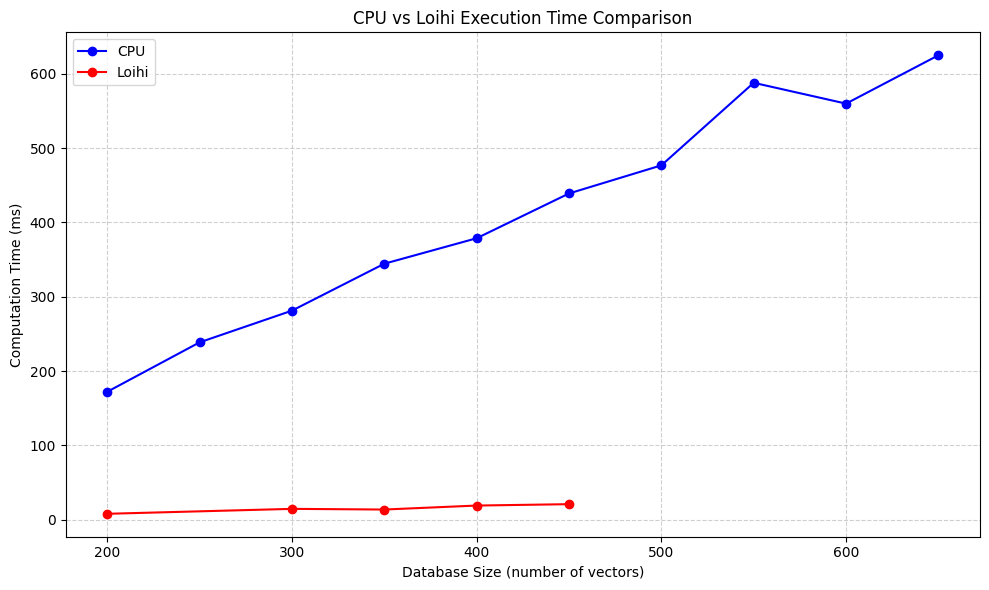

In [13]:
# Get the data points for both CPU and Loihi
cpu_sizes = sizes  # From your previous experiment
cpu_times = times  # From your previous experiment

loihi_sizes = db_values  
loihi_times = execution_time  

# Create the comparison plot
plt.figure(figsize=(10, 6))
plt.plot(cpu_sizes, cpu_times, 'bo-', label='CPU')
plt.plot(loihi_sizes, loihi_times, 'ro-', label='Loihi')

plt.xlabel('Database Size (number of vectors)')
plt.ylabel('Computation Time (ms)')
plt.title('CPU vs Loihi Execution Time Comparison')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()